The following is a simple script that performs an astrophysical neutrino source class search using three years worth of publicly available IceCube muon track data and the 4LAC catalog from the Fermi satellite, a catalog of gamma-ray active galactic nuclei in the universe detected by the satellite. 

For points in the sky from the 4LAC catalog, the script scans over the number of neutrinos in the data from the source class and calculates the likelihood. The number of neutrinos associated to each source in the source class is determined by a weighting, which is described in more detail in the paper. For this example, I use a `flat` weight, treating each source in the class as equal. If a statistically significant number of tracks in the data are associated with this source class, the resulting likelihood will peak above 3$\sigma$. 

First, we load common libraries and `IceCubeAnalysis`, a custom library with two classes, the first (`SourceSearch`) that handle the creation of the neutrino source likelihood function given a source location to test and the second (`SourceClassSearch`) that handles the loading of 4LAC sources. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IceCubeAnalysis

Now that we know all the points on the sky, we create a new `SourceSearch` instance and load the pre-processed muon track data and background PDF.

In [2]:
sourcesearch_ = IceCubeAnalysis.SourceSearch("./processed_data/output_icecube_data.npz")
sourcesearch_.load_background("./processed_data/output_icecube_background_count.npz")

We need to define some parameters of the analysis, including the time of the analysis (`T`), energy bands of interest for plotting (`E1` and `E2`), the power spetrum of the neutrino flux (`alpha`), how to weight each source (`weights_type`), and the source class names of interest (`source_class_names`). 

In [3]:
T = (3.0 * 365.25 * 24.0 * 3600.0)
E1 = 100.0
E2 = 30.0
alpha = 2.0
weights_type = 'flat'
source_class_names = ['FSRQ', 'fsrq']

Next we load up the source class information, defined in `IceCubeAnalysis`, `SourceClassSearch`, using the 4LAC catalog pre-processed in `./processed_data/4LAC_catelogy.npz`. 

In [4]:
Aeff_filename = "processed_data/output_icecube_AffIntegrated_%s.npz" % alpha
class_search = IceCubeAnalysis.SourceClassSearch(T, E1, E2, alpha, sourcesearch_, Aeff_filename)
    
class_search.load_4lac("./processed_data/4LAC_catelogy.npz", source_class_names, weights_type)
    
print("Number of Sources:\t %i" % class_search.N)
print("Number of Events:\t %i" % sourcesearch_.N)

Number of Sources:	 658
Number of Events:	 334677


Since it is computationally intensive to run the source search, I parallelize the computation. For overhead purposes, it is more efficient to run the scan over flux for each individual source per job and then combine them in post-processing. The `SourceClassSearch` instance performs the sweep on each individual source in the class using the function `source_loop` which accepts the integer of the source of interest. 

In [5]:
import time
from multiprocessing import Pool
n_cpu = 4

start_time = time.time()                        
pool = Pool(n_cpu)
parallel_results = pool.map(class_search.source_loop, np.arange(class_search.N))
pool.close()
end_time = time.time()
print("Using parallel, time passed was: \t %f" % (end_time - start_time))

Using parallel, time passed was: 	 3.120610


With the big computing done, the result is saved into `parallel_results`. The post processing to combine each source into one likelihood vs. flux measurement is below. 

In [6]:

parallel_results = [list(t) for t in zip(*parallel_results)]

sweep_ts_each_source = np.stack(parallel_results[1], axis=1)
sweep_ts = np.sum(parallel_results[1], axis=0)
sweep_flux = np.sum(parallel_results[0], axis=0)

sweep_flux *= 1000.0 # convert TeV to GeV

And now a plot of the results. 

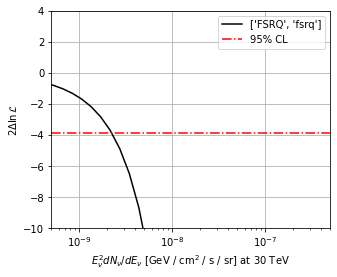

In [7]:
plt.figure(figsize=(5, 4))
plt.semilogx(np.array(sweep_flux)[sweep_ts < 1e3],
             sweep_ts[sweep_ts < 1e3],
             linestyle='-',
             color='black',
             label=source_class_names)

plt.axhline(-3.85,
            color="red",
            linestyle="-.",
            label="95% CL")
            
plt.xlabel(r"$E^2_\nu dN_\nu/dE_\nu$ [GeV / cm$^2$ / s / sr] at 30 TeV")
plt.ylabel("$2 \Delta \ln \mathcal{L}$")
plt.xlim(5e-10, 5e-7)
plt.ylim(-10.0, 4.0)
plt.grid()
plt.legend()

To perform the search over more sources and for other flux weight hypotheses, I import the processing script from `A05_analyze_source_classes_limits.py.` The following block of code takes ~80 s to complete using the parallelized version of the source finding code. 

Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 12.680658
Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 12.742057
Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 12.249735
Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 11.119059
Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 11.472452
Number of Sources:	 2774
Number of Events:	 334677
Using parallel, time passed was: 	 11.530322


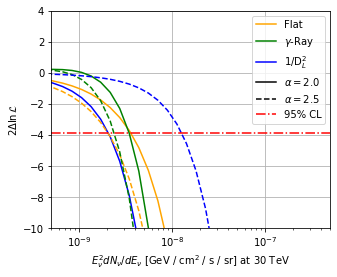

In [9]:
from A05_analyze_source_classes_limits import main

catalog_file_name = "./processed_data/4LAC_catelogy.npz"
icecube_file_name = "./processed_data/output_icecube_data.npz"
background_file_name = "./processed_data/output_icecube_background_count.npz"

source_class_names = ['FSRQ', 'bll', 'FSRQ', 'fsrq', 'BCU', 'bcu']

weights_types = ['flat', 'flux', 'dist']
colors = ['orange', 'green', 'blue']
labels = ['Flat', r'$\gamma$-Ray', r'1/D$_L^2$']

alphas = [2.0, 2.5]
linestyles = ['-', '--']

plt.figure(figsize=(5, 4))
for i_alpha, alpha in enumerate(alphas):
    for i_weights_type, weights_type in enumerate(weights_types):
        sweep_flux, sweep_ts, sweep_ts_each_source = main(icecube_file_name=icecube_file_name,
                                                          background_file_name=background_file_name,
                                                          catalog_file_name=catalog_file_name,
                                                          source_class_names=source_class_names,
                                                          alpha=alpha,
                                                          weights_type=weights_type,
                                                          n_cpu=4,
                                                          var_index_cut=None)

        plt.semilogx(np.array(sweep_flux)[sweep_ts < 1e3],
                     sweep_ts[sweep_ts < 1e3],
                     linestyle=linestyles[i_alpha],
                     color=colors[i_weights_type])

for i_weights_type, weights_type in enumerate(weights_types):
    plt.plot([], [], color=colors[i_weights_type], label=labels[i_weights_type])

for i_alpha, alpha in enumerate(alphas):
    plt.plot([], [], color='black', linestyle=linestyles[i_alpha], label=r"$\alpha=$" + str(alpha))

plt.axhline(-3.85,
            color="red",
            linestyle="-.",
            label="95% CL")

plt.xlabel(r"$E^2_\nu dN_\nu/dE_\nu$ [GeV / cm$^2$ / s / sr] at 30 TeV")
plt.ylabel("$2 \Delta \ln \mathcal{L}$")
plt.xlim(5e-10, 5e-7)
plt.ylim(-10.0, 4.0)
plt.grid()
plt.legend()

plt.savefig("./plots/A05_analyze_source_classes_limits_no_var_cut.png", dpi=300)